#   Pricing of American Option using Random Forest regression : 1 asset 

Let us first import all the useful packages, especially the scikit-learn package for random forest

In [9]:
%pylab inline --no-import-all
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import pandas as pd
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



Populating the interactive namespace from numpy and matplotlib


Let us create the N stocks observations following the Black Scholes model.

In [10]:
def generate_paths(S0, dt , sigma, r, N, m,q):
    '''
    Function to generte stock paths.
    
    Parameters
    ==========
    S0    : float
            positive, initial Stock Value
    dt    : float
            time step discretization
    sigma : float 
            volatility 
    r     : float
            bond return 
    N     : int 
            Number of paths generated      
    m     : int 
            number of steps
    
    Returns
    =======
    S : matrix
        generated paths
    '''
    
    S = np.zeros((m + 1,N))
    S[0] = S0
    for t in range(1, m + 1):
        rand = np.random.standard_normal(N)
        S[t] = S[t - 1] * np.exp((r -q- sigma ** 2 / 2) * dt + sigma * dt ** 0.5 * rand)
    return S

In [11]:
def exercise_matrix(K,S):
    ''' 
    Function to define the ealy exercise matrix.
    
    Parameters
    ==========
    S     : Matrix
            Stock Values 
    K     : float 
            Strike price
    
    Returns
    =======
    h : matrix
        early exercise for a call american option
    '''
    
    h=np.maximum(S-K,0)
    return h


Let's compute the following dynamic pricing algorithm using the Random Forest Regressor : 

$
\begin{equation} 
V_t = \max {(\mathbb{E}[e^{-r\Delta t} V_{t+\Delta t} | 
                                S_t], h_t)} \\
V_m = (S_m - K , 0)^+                              
\end{equation}
$

In [12]:
def pricing_option(K,r,sigma,N,m,S_0,T, RF_n_estimators,RF_max_leaf_nodes,q):
    '''
    Function to generte stock paths.
    
    Parameters
    ==========
    S_0             : float
                      positive, initial Stock Value
    K               : float 
                      Strike price
    T               : float 
                      Maturity time 
    RF_n_estimators : int 
                      Number of trees generated by the Random Forest regression
                      
    RF_max_leaf_    : int 
    nodes             Maximum number of leafs for every branch of the tree generated
    
    sigma           : float 
                      volatility 
    r               : float
                      bond return 
    N               : int 
                      Number of paths generated      
    m               : int 
                      number of steps
    q               : float 
                      the dividend the stock pays
    
    Returns
    =======
    V_opt : float
            Price of the option
    '''  
        
    #Time-step
    dt=T/m
    #Discount factor
    df=math.exp(-r*dt)
    #Creation of a stock path matrix
    S=generate_paths(S_0, dt , sigma, r, N, m,q)
    #Creation of the exercise price matrix
    h=exercise_matrix(K,S)
    #price of the option at time T = Initialization
    V=h[-1]    

    #Iteration over time
    for t in range (m-1,0,-1): 
        X=S[t]
        X=X[:,None]
        
        #Random Forest algorithm uses the j'th time of the Stock and the (j+1)'th time of Option Price to fit 
        rf=RandomForestRegressor(n_estimators=RF_n_estimators,
                                max_leaf_nodes=RF_max_leaf_nodes,oob_score=False, n_jobs=-1)
        rf.fit(X,V)
        B=rf.predict(X)
        V=np.where(h[t] > B, h[t], df*V)
    
    V_opt= df*np.mean(V)
    return (V_opt)

__________


Example 


____

In [6]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
N=10000
RF_n_estimators=50
RF_max_leaf_nodes=10

price=pricing_option(K,r,sigma,N,m,S_0,T,RF_n_estimators,RF_max_leaf_nodes,q)
print ('price = ', price)


price =  10.0484612466


<img src="../Figures/xia_Aoption_1D.png">

### Time Performance Analysis

____


In [8]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
N=10000
RF_n_estimators=5
RF_max_leaf_nodes=10

%timeit price=pricing_option(K,r,sigma,N,m,S_0,T,RF_n_estimators,RF_max_leaf_nodes,q)
print ('price = ', price)

1 loop, best of 3: 2.76 s per loop
price =  9.92637415866


_________

### Simulations

#### Number of paths generated N increasing : 

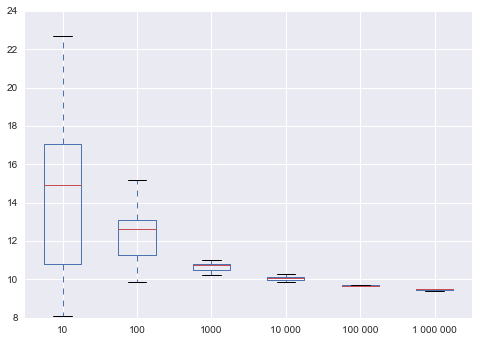

In [9]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
RF_n_estimators=5
RF_max_leaf_nodes=10

n = [10,100,1000,10000,100000,1000000]


Prices=[]

for N in n:
    Prices_int=[]
    for i in range (15): 
        f = price=pricing_option(K,r,sigma,N,m,S_0,T,RF_n_estimators,RF_max_leaf_nodes,q)
        Prices_int.append(f)
    Prices.append(Prices_int)
    
df = pd.DataFrame(np.transpose(Prices), columns=['10','100', '1000', '10 000', '100 000', '1 000 000'])

df.plot(kind='box')
plt.show()

We fix here parameters for the Random Forest regression and plot the simulations with the number of paths generated varying. 
We can notice a variance converging to 0, and a mean value converging to 9.7 approximatively. 
A number of 10 000 paths seems enough for our next simulations. 

________

#### Number of trees in Random Forest

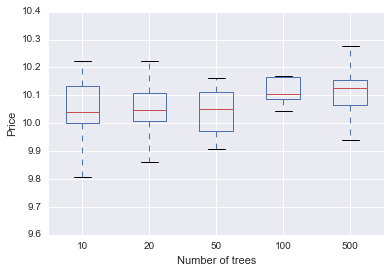

'We price'

In [26]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
N = 10000
RF_max_leaf_nodes=10


RF_n_estimators_range=[10,20,50, 100, 500]
Prices=[]

for RF_n_estimators in RF_n_estimators_range:
    Prices_int=[]
    for i in range (10): 
        Prices_int.append(pricing_option(K,r,sigma,N,m,S_0,T,RF_n_estimators,RF_max_leaf_nodes,q))
        
    Prices.append(Prices_int)
  

    
df = pd.DataFrame(np.transpose(Prices), columns=['10','20', '50',
                                                 '100', '500'])

df.plot(kind='box')
plt.xlabel('Number of trees')
plt.ylabel('Price')
plt.show()

"We price"    


The Price is not so sensitive with number of trees, but we get the most accurate result for 50 trees generated by the Random Forest Regressor. 


#### Number of max_leaf_nodes

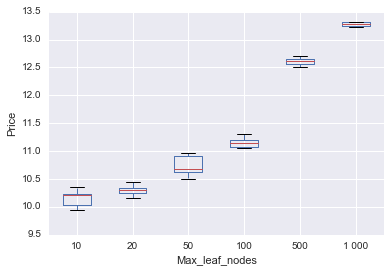

'We price'

In [29]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
RF_n_estimators=50


RF_max_leaf_nodes_range=[10,20,50,100,500,1000]
Prices=[]

for RF_max_leaf_nodes in RF_max_leaf_nodes_range:
    Prices_int=[]
    for i in range (10): 
        Prices_int.append(pricing_option(K,r,sigma,N,m,S_0,T,RF_n_estimators,RF_max_leaf_nodes,q))
        
    Prices.append(Prices_int)
  

    
df = pd.DataFrame(np.transpose(Prices), columns=['10','20', '50', '100','500','1 000'])

df.plot(kind='box')
plt.xlabel('Max_leaf_nodes')
plt.ylabel('Price')
plt.show()

"We price"    


The parameter max_leaf_nodes has got a real impact on the price. An increasing number should avoid overfitting, but here it seems to be having the opposite effect. It might be better to analyze the performance on a smaller interval : 

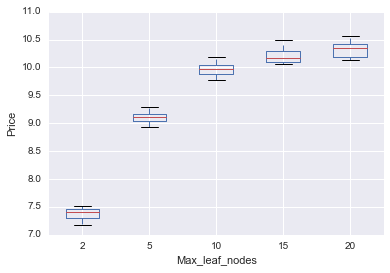

'We price'

In [31]:
T=1
m=12
K=100.
S_0=100.
r=0.1
q=0.05
sigma=0.2
RF_n_estimators=5


RF_max_leaf_nodes_range=[2,5,10,15,20]
Prices=[]

for RF_max_leaf_nodes in RF_max_leaf_nodes_range:
    Prices_int=[]
    for i in range (10): 
        Prices_int.append(pricing_option(K,r,sigma,N,m,S_0,
                                         T,RF_n_estimators,
                                         RF_max_leaf_nodes,q))
        
    Prices.append(Prices_int)
  

    
df = pd.DataFrame(np.transpose(Prices), columns=['2',
                                                 '5', '10',
                                                 '15','20'])

df.plot(kind='box')
plt.xlabel('Max_leaf_nodes')
plt.ylabel('Price')
plt.show()

15 seems to be good for 50 trees generated. 
Let's simulate the variations of the price with both parameters

### 3D visualization of both parameters impact

In [14]:
trees = np.linspace(10, 100, 10)
max_leaf_nodes = np.linspace(2, 50, 25)
trees, max_leaf_nodes = np.meshgrid(trees, max_leaf_nodes)

TypeError: unorderable types: list() <= int()

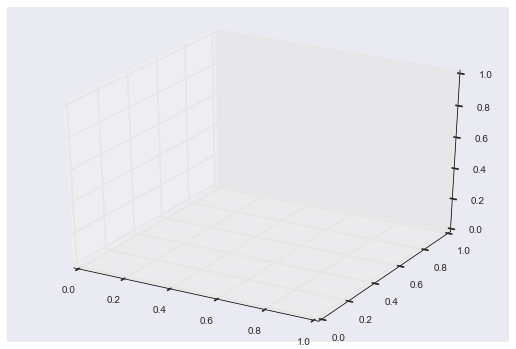

In [15]:
from mpl_toolkits.mplot3d import Axes3D


def z_func(nb_trees, leaf_nodes): 
    T=1
    m=12
    K=100.
    S_0=100.
    r=0.1
    q=0.05
    sigma=0.2
    
    return pricing_option(K,r,sigma,N,m,S_0,T, nb_trees, leaf_nodes,q)

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')


f = z_func([nb_trees for nb_trees in trees], [leaf_nodes for leaf_nodes in max_leaf_nodes])

Still working on this